# Model Performance By Day

The purpose of this notebook is to get accuracy numbers for trades that have occurred. The user needs to input the date of the model that is of interest, and optionally, the date of the trades that occurred. If no date of trades is provided, then the trade date is assumed to be the model date. This notebook allows the user to answer the question: how would the model deployed on `Date1` do on trades from `Date2`?

Simplified the problem by using the `historical_predictions.historical_predictions` table since calling `get_trades_on_date_of_interest(...)` is a very slow procedure because of the `.to_dataframe()` call when converting the result from BigQuery to a dataframe.

In [1]:
import os
import sys
import warnings
from IPython.display import display

import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import matplotlib.pyplot as plt

from point_in_time_pricing_actual_trades import get_trades_on_date_of_interest_query, \
                                                get_trades_on_date_of_interest_from_query, \
                                                price_trades_at_different_quantities_trade_types


__file__ = os.path.abspath('model_performance_by_day.ipynb')    # in a Jupyter Notebook, the `__file__` variable is not automatically defined because notebooks do not run as standard Python scripts
ficc_python_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..', '..', 'ficc_python'))    # get the directory containing the 'app_engine/demo/server' package
sys.path.append(ficc_python_dir)    # add the directory to sys.path
print('NOTE: this file must be run from the `notebooks/point_in_time_pricing/` directory')

from automated_training_auxiliary_functions import segment_results
from automated_training_yield_spread_model import apply_exclusions


utils_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..', 'app_engine', 'demo', 'server', 'modules', 'ficc', 'utils'))    # get the directory containing the 'app_engine/demo/server' package
sys.path.append(utils_dir)    # add the directory to sys.path

from auxiliary_functions import process_ratings
from fill_missing_values import fill_missing_values

NOTE: this file must be run from the `notebooks/point_in_time_pricing/` directory
INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
NOTE: this file must be run from the `notebooks/point_in_time_pricing/` directory
Initializing pandarallel with 5.0 cores
INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
In PRODUCTION mode (to change to TESTING mode, set `TESTING` to `True`); all files and models will be saved and NUM_EPOCHS=100


/Users/user/ficc/ficc_python/automated_training_auxiliary_functions.py:104: UserWarning: No GPUs found
  warnings.warn('No GPUs found')


In [2]:
sys.version

'3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]'

In [3]:
dates_of_interest = ['2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08']

# Getting the data from `historical_predictions`

In [4]:
def get_predictions_on_date_of_interest(date_or_dates_of_interest):
    assert type(date_or_dates_of_interest) == list or type(date_or_dates_of_interest) == str, f'Incorrect type for `date_or_dates_of_interest`: {type(date_or_dates_of_interest)}, must be list or string'
    if type(date_or_dates_of_interest) == list:    # list of dates
        date_condition = f'IN {tuple(date_or_dates_of_interest)}'
    else:    # single date
        date_condition = f'= "{date_or_dates_of_interest}"'
    date_condition = f'trade_date {date_condition}'

    historical_predictions_table_columns = ['rtrs_control_number', 'cusip', 'trade_date', 'dollar_price', 'yield', 'new_ficc_ycl', 'new_ys', 'new_ys_prediction', 'prediction_datetime']
    query = f'''SELECT {', '.join(historical_predictions_table_columns)} FROM `historic_predictions.historical_predictions` WHERE {date_condition}'''
    print('query from `get_predictions_on_date_of_interest(...)`:\n', query)

    return get_trades_on_date_of_interest_from_query(query, date_or_dates_of_interest, False)

In [5]:
df = get_predictions_on_date_of_interest(dates_of_interest)
df = df.sort_values(by='prediction_datetime')
df = df.drop_duplicates(subset='rtrs_control_number')    # only keeps the first occurrence for an RTRS control number for the most recent `prediction_datetime`
assert any(df['rtrs_control_number'].duplicated()) is False, 'There are duplicate RTRS control numbers in `df`'

query from `get_predictions_on_date_of_interest(...)`:
 SELECT rtrs_control_number, cusip, trade_date, dollar_price, yield, new_ficc_ycl, new_ys, new_ys_prediction, prediction_datetime FROM `historic_predictions.historical_predictions` WHERE trade_date IN ('2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08')
Begin execution of get_trades_on_date_of_interest_from_query
Execution time of get_trades_on_date_of_interest_from_query: 0:00:03.811254


In [6]:
df

,rtrs_control_number,cusip,trade_date,dollar_price,yield,new_ficc_ycl,new_ys,new_ys_prediction,prediction_datetime
68064,2024030406078900,729192EM2,2024-03-04,100.360,341.8,328.560411,13.239589,16.090809,2024-03-05 13:11:54
56588,2024030401129000,41423PCS4,2024-03-04,104.762,296.3,293.434015,2.865985,7.233386,2024-03-05 13:11:54
56587,2024030401548200,67759HJA3,2024-03-04,105.697,282.0,293.434015,-11.434015,-13.442429,2024-03-05 13:11:54
56586,2024030401799100,91878DAE9,2024-03-04,102.896,289.0,293.434015,-4.434015,-6.752410,2024-03-05 13:11:54
56585,2024030401761500,91878DAE9,2024-03-04,102.896,289.0,293.434015,-4.434015,-7.640584,2024-03-05 13:11:54
...,...,...,...,...,...,...,...,...,...
25852,2024030810284500,079694BC8,2024-03-08,95.079,357.5,285.524091,71.975909,67.405159,2024-03-11 15:56:43
25853,2024030810055700,668844TR4,2024-03-08,88.763,473.4,285.524091,187.875909,183.437271,2024-03-11 15:56:43
25850,2024030809535500,593842CR6,2024-03-08,92.585,424.9,386.982671,37.917329,36.752644,2024-03-11 15:56:43
25849,2024030809536100,593842CR6,2024-03-08,92.585,424.9,386.982671,37.917329,30.479160,2024-03-11 15:56:43


Get the reference data to slice the data and apply exclusions as we do when evaluating the yield spread model.

In [7]:
features_needed_for_slicing_and_exclusions = ['rtrs_control_number', 'trade_type', 'sp_long', 'par_traded', 'next_call_date', 'refund_date', 'maturity_date', 'par_call_date', 'settlement_date']

In [ ]:
query = get_trades_on_date_of_interest_query(dates_of_interest)
# remove the features (which are located before the `FROM` statement)
from_pos = query.find(' FROM')
query = 'SELECT ' + ', '.join(features_needed_for_slicing_and_exclusions) + query[from_pos:]
print(query)
df_with_reference_data = get_trades_on_date_of_interest_from_query(query, dates_of_interest, False)

In [9]:
def process_features(df):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', RuntimeWarning)    # ignore `pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10` since we handle this directly by filling in -np.inf with np.nan
        warnings.simplefilter('ignore', SettingWithCopyWarning)    # the following np.log10 assignments cause `SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_indexer,col_indexer] = value instead`
        df.loc[:, 'days_to_maturity'] =  np.log10(1 + (df.maturity_date - df.settlement_date).dt.days)
        df.loc[:, 'days_to_call'] = np.log10(1 + (df.next_call_date - df.settlement_date).dt.days)
        df.loc[:, 'days_to_refund'] = np.log10(1 + (df.refund_date - df.settlement_date).dt.days)
        df.loc[:, 'days_to_par'] = np.log10(1 + (df.par_call_date - df.settlement_date).dt.days)
        df.loc[:, 'call_to_maturity'] = np.log10(1 + (df.maturity_date - df.next_call_date).dt.days)
    return df

In [10]:
df_with_reference_data = process_features(df_with_reference_data)
df_with_reference_data = process_ratings(df_with_reference_data, False)
df_with_reference_data = fill_missing_values(df_with_reference_data)
df_with_reference_data = df_with_reference_data.drop(columns=[feature for feature in features_needed_for_slicing_and_exclusions if feature.endswith('_date')] + ['sp_long'])

Feature purpose_class not in dataframe. Error: 'purpose_class'
Feature call_timing not in dataframe. Error: 'call_timing'
Feature call_timing_in_part not in dataframe. Error: 'call_timing_in_part'
Feature sink_frequency not in dataframe. Error: 'sink_frequency'
Feature sink_amount_type not in dataframe. Error: 'sink_amount_type'
Feature issue_text not in dataframe. Error: 'issue_text'
Feature state_tax_status not in dataframe. Error: 'state_tax_status'
Feature series_name not in dataframe. Error: 'series_name'
Feature transaction_type not in dataframe. Error: 'transaction_type'
Feature next_call_price not in dataframe. Error: 'next_call_price'
Feature par_call_price not in dataframe. Error: 'par_call_price'
Feature min_amount_outstanding not in dataframe. Error: 'min_amount_outstanding'
Feature max_amount_outstanding not in dataframe. Error: 'max_amount_outstanding'
Feature issue_amount not in dataframe. Error: 'issue_amount'
Feature maturity_amount not in dataframe. Error: 'maturity_a

In [11]:
df_with_reference_data

,rtrs_control_number,trade_type,par_traded,days_to_maturity,days_to_call,days_to_refund,days_to_par,call_to_maturity,rating
0,2024030608723300,S,300000.000000000,3.495544,1.477121,0.000000,1.477121,3.491502,BB-
1,2024030608710100,D,10000.000000000,3.784118,1.301030,0.000000,1.301030,3.782759,CCC+
2,2024030608710000,P,10000.000000000,3.784118,1.301030,0.000000,1.301030,3.782759,CCC+
3,2024030608726000,S,15000.000000000,3.870462,2.064458,2.064458,2.064458,3.863680,BBB
4,2024030608707700,D,15000.000000000,3.870462,2.064458,2.064458,2.064458,3.863680,BBB
...,...,...,...,...,...,...,...,...,...
227091,2024030806215700,S,40000.000000000,3.870228,3.081707,0.000000,3.081707,3.793162,BBB+
227092,2024030806085800,P,25000.000000000,1.707570,0.000000,0.000000,0.000000,0.000000,BBB+
227093,2024030806034400,D,35000.000000000,3.813247,0.000000,0.000000,0.000000,0.000000,BBB+
227094,2024030806027800,P,35000.000000000,3.813247,0.000000,0.000000,0.000000,0.000000,BBB+


In [12]:
merged_df = pd.merge(df, df_with_reference_data, on='rtrs_control_number')

In [13]:
merged_df

,rtrs_control_number,cusip,trade_date,dollar_price,yield,new_ficc_ycl,new_ys,new_ys_prediction,prediction_datetime,trade_type,par_traded,days_to_maturity,days_to_call,days_to_refund,days_to_par,call_to_maturity,rating
0,2024030406078900,729192EM2,2024-03-04,100.360,341.8,328.560411,13.239589,16.090809,2024-03-05 13:11:54,S,25000.000000000,1.944483,0.000000,0.0,0.000000,0.000000,AA
1,2024030401129000,41423PCS4,2024-03-04,104.762,296.3,293.434015,2.865985,7.233386,2024-03-05 13:11:54,S,20000.000000000,2.950851,0.000000,0.0,0.000000,0.000000,MR
2,2024030401548200,67759HJA3,2024-03-04,105.697,282.0,293.434015,-11.434015,-13.442429,2024-03-05 13:11:54,S,60000.000000000,3.391288,3.000434,0.0,3.000434,3.164947,AA+
3,2024030401799100,91878DAE9,2024-03-04,102.896,289.0,293.434015,-4.434015,-6.752410,2024-03-05 13:11:54,D,30000.000000000,3.000434,0.000000,0.0,0.000000,0.000000,MR
4,2024030401761500,91878DAE9,2024-03-04,102.896,289.0,293.434015,-4.434015,-7.640584,2024-03-05 13:11:54,S,30000.000000000,3.000434,0.000000,0.0,0.000000,0.000000,MR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224874,2024030810284500,079694BC8,2024-03-08,95.079,357.5,285.524091,71.975909,67.405159,2024-03-11 15:56:43,S,35000.000000000,3.086716,2.691081,0.0,2.691081,2.863917,MR
224875,2024030810055700,668844TR4,2024-03-08,88.763,473.4,285.524091,187.875909,183.437271,2024-03-11 15:56:43,D,40000.000000000,3.086716,0.000000,0.0,0.000000,0.000000,AAA
224876,2024030809535500,593842CR6,2024-03-08,92.585,424.9,386.982671,37.917329,36.752644,2024-03-11 15:56:43,P,10000.000000000,3.937769,3.188366,0.0,3.188366,3.852663,MR
224877,2024030809536100,593842CR6,2024-03-08,92.585,424.9,386.982671,37.917329,30.479160,2024-03-11 15:56:43,D,10000.000000000,3.937769,3.188366,0.0,3.188366,3.852663,MR


Apply same exclusions as yield spread model training.

In [14]:
merged_df, merged_df_without_exclusions = apply_exclusions(merged_df)

Removed 23287 trades for having 0 < days_to_call <= 400
Removed 1027 trades for having 0 < days_to_refund <= 400
Removed 15411 trades for having 0 < days_to_maturity <= 400
Removed 69 trades for having days_to_maturity >= 30000


Create an accuracy table for every day of the week.

In [15]:
for date in dates_of_interest:
    merged_df_date = merged_df[merged_df['trade_date'].astype('string') == date]
    results = segment_results(merged_df_date, np.abs(merged_df_date['new_ys'] - merged_df_date['new_ys_prediction']))
    print(date)
    display(results)

2024-03-04


,Mean Absolute Error,Trade Count
Entire set,7.932,37095
Dealer-Dealer,7.784,14129
Bid Side / Dealer-Purchase,8.177,9082
Offered Side / Dealer-Sell,7.922,13884
AAA,6.868,6143
Investment Grade,7.733,30251
Trade size >= 100k,6.681,7596


2024-03-05


,Mean Absolute Error,Trade Count
Entire set,8.148,38400
Dealer-Dealer,7.893,14098
Bid Side / Dealer-Purchase,9.016,10288
Offered Side / Dealer-Sell,7.767,14014
AAA,7.063,6166
Investment Grade,7.897,30947
Trade size >= 100k,7.302,8609


2024-03-06


,Mean Absolute Error,Trade Count
Entire set,8.406,38817
Dealer-Dealer,8.040,14614
Bid Side / Dealer-Purchase,9.397,10162
Offered Side / Dealer-Sell,8.071,14041
AAA,7.005,5919
Investment Grade,8.186,31399
Trade size >= 100k,7.202,10289


2024-03-07


,Mean Absolute Error,Trade Count
Entire set,8.346,39325
Dealer-Dealer,8.151,14049
Bid Side / Dealer-Purchase,8.988,10857
Offered Side / Dealer-Sell,8.051,14419
AAA,7.832,6295
Investment Grade,8.272,30822
Trade size >= 100k,7.469,9529


2024-03-08


,Mean Absolute Error,Trade Count
Entire set,7.647,31448
Dealer-Dealer,7.770,11316
Bid Side / Dealer-Purchase,7.920,8067
Offered Side / Dealer-Sell,7.350,12065
AAA,6.683,4914
Investment Grade,7.491,25398
Trade size >= 100k,6.391,6453


Create a histogram of the accuracy for every slice of the data on a particular day.

In [16]:
date_of_interest = '2024-03-08'

In [17]:
merged_df_date_of_interest = merged_df[merged_df['trade_date'].astype('str') == date_of_interest]
merged_df_date_of_interest

,rtrs_control_number,cusip,trade_date,dollar_price,yield,new_ficc_ycl,new_ys,new_ys_prediction,prediction_datetime,trade_type,par_traded,days_to_maturity,days_to_call,days_to_refund,days_to_par,call_to_maturity,rating
186306,2024030806820600,07652CBA6,2024-03-08,71.250,445.7,375.153041,70.546959,71.463852,2024-03-11 15:56:43,D,10000.000000000,3.898670,3.128399,0.0,3.128399,3.817962,MR
186307,2024030807136300,385789DF6,2024-03-08,100.000,412.5,417.250459,-4.750459,-9.395994,2024-03-11 15:56:43,S,50000.000000000,4.039295,3.561340,0.0,3.561340,3.863680,AA
186308,2024030808758400,803770WF9,2024-03-08,85.820,486.4,280.304554,206.095446,168.484711,2024-03-11 15:56:43,P,30000.000000000,3.240549,3.003891,0.0,3.003891,2.864511,A+
186312,2024030803688900,649807CX0,2024-03-08,97.842,413.4,402.998022,10.401978,2.009059,2024-03-11 15:56:43,S,55000.000000000,3.990871,3.395676,0.0,3.395676,3.863680,A+
186313,2024030803689400,649807CX0,2024-03-08,97.709,414.2,402.998022,11.201978,15.911427,2024-03-11 15:56:43,P,55000.000000000,3.990871,3.395676,0.0,3.395676,3.863680,A+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224874,2024030810284500,079694BC8,2024-03-08,95.079,357.5,285.524091,71.975909,67.405159,2024-03-11 15:56:43,S,35000.000000000,3.086716,2.691081,0.0,2.691081,2.863917,MR
224875,2024030810055700,668844TR4,2024-03-08,88.763,473.4,285.524091,187.875909,183.437271,2024-03-11 15:56:43,D,40000.000000000,3.086716,0.000000,0.0,0.000000,0.000000,AAA
224876,2024030809535500,593842CR6,2024-03-08,92.585,424.9,386.982671,37.917329,36.752644,2024-03-11 15:56:43,P,10000.000000000,3.937769,3.188366,0.0,3.188366,3.852663,MR
224877,2024030809536100,593842CR6,2024-03-08,92.585,424.9,386.982671,37.917329,30.479160,2024-03-11 15:56:43,D,10000.000000000,3.937769,3.188366,0.0,3.188366,3.852663,MR


In [18]:
inter_dealer = lambda data: data.trade_type == 'D'
dealer_purchase = lambda data: data.trade_type == 'P'
dealer_sell = lambda data: data.trade_type == 'S'
aaa = lambda data: data.rating == 'AAA'
investment_grade_ratings = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
investment_grade = lambda data: data.rating.isin(investment_grade_ratings)
hundred_k = lambda data: data.par_traded >= 1e5

slice_functions = [(inter_dealer, 'Inter-Dealer'), 
                   (dealer_purchase, 'Bid Side / Dealer-Purchase'), 
                   (dealer_sell, 'Offered Side / Dealer-Sell'), 
                   (aaa, 'AAA'), 
                   (investment_grade, 'Investment Grade'), 
                   (hundred_k, 'Trade size >= 100k')]

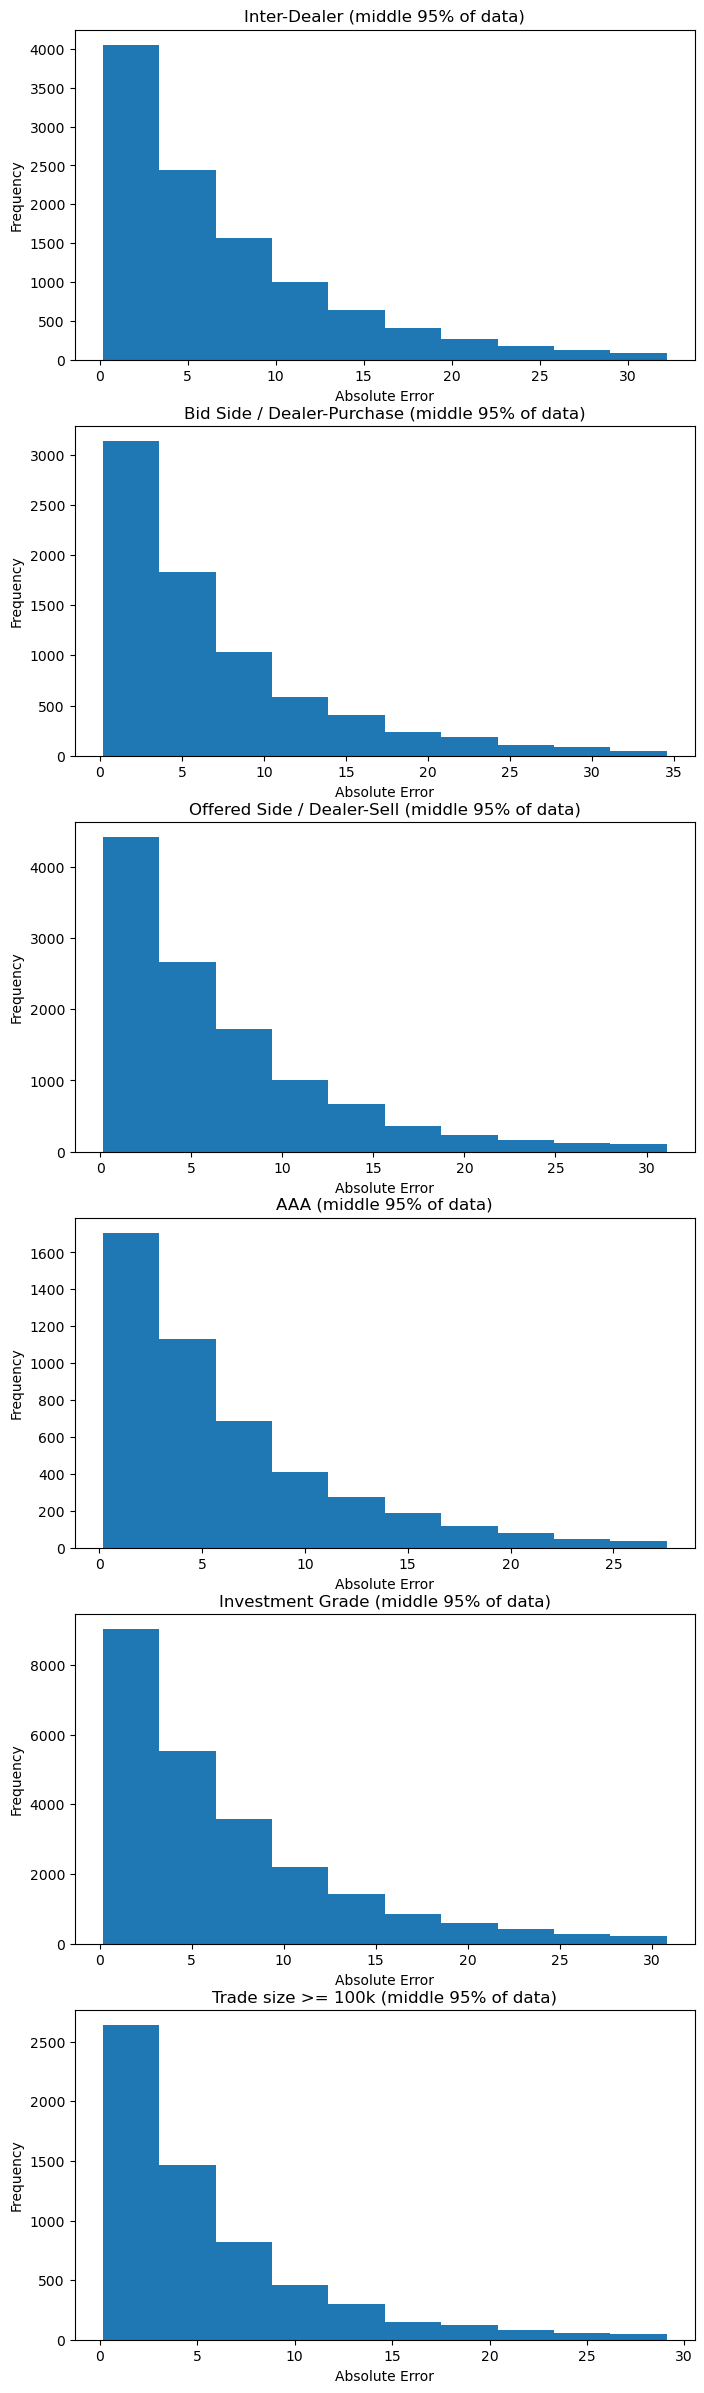

In [27]:
fig, axs = plt.subplots(6, 1, figsize=(8, 30))
for idx, ax in enumerate(axs):
    slice_function, name = slice_functions[idx]
    merged_df_date_of_interest_sliced = merged_df_date_of_interest[slice_function(merged_df_date_of_interest)]
    new_ys_abs_diff = np.abs(merged_df_date_of_interest_sliced['new_ys'] - merged_df_date_of_interest_sliced['new_ys_prediction'])

    lower_percentile = np.percentile(new_ys_abs_diff, 2.5)
    upper_percentile = np.percentile(new_ys_abs_diff, 97.5)
    new_ys_abs_diff_percentile = new_ys_abs_diff[(new_ys_abs_diff >= lower_percentile) & (new_ys_abs_diff <= upper_percentile)]

    ax.hist(new_ys_abs_diff_percentile)
    ax.set_xlabel('Absolute Error')
    ax.set_ylabel('Frequency')
    ax.set_title(name + ' (middle 95% of data)')

# Getting the data from `trade_history_same_issue_5_yr_mat_bucket_1_materialized` and predicting the prices

In [ ]:
query = get_trades_on_date_of_interest_query(dates_of_interest)
df = get_trades_on_date_of_interest_from_query(query, dates_of_interest, False)

## Single day

Get predictions using the model deployed on the date of interest for the trades on the date of interest.

In [ ]:
date_of_interest = '2024-03-04'

In [ ]:
def price_trades_for_date_of_interest(date_of_interest):
    df_date_of_interest = df[(df['trade_date'] == date_of_interest) & (df['publish_date'] == date_of_interest)]
    return df_date_of_interest, price_trades_at_different_quantities_trade_types(df_date_of_interest, date_of_interest)

In [ ]:
df_date_of_interest, priced_trades_for_date_of_interest = price_trades_for_date_of_interest(date_of_interest)
priced_trades_for_date_of_interest.head(10)
priced_trades_for_date_of_interest.tail(10)

In [ ]:
yield_predictions_for_date_of_interest = priced_trades_for_date_of_interest['ytw']
df_date_of_interest['yield_prediction'] = yield_predictions_for_date_of_interest

Create a histogram of all of the errors where the x-axis is the absolute error and the y-axis is the count.

In [ ]:
plt.hist(yield_predictions_for_date_of_interest)
plt.xlabel('MAE')
plt.ylabel('Frequency')

Perform procedure on many slices of data. Slices taken directly from `ficc_python/automated_training_auxiliary_functions.py::segment_results(...)`.

In [ ]:
for slice_function in (inter_dealer, dealer_purchase, dealer_sell, aaa, investment_grade):
    sliced_df_date_of_interest = inter_dealer(df_date_of_interest)
    plt.hist(sliced_df_date_of_interest['yield_prediction'])

## Multiple days

In [ ]:
for date in dates_of_interest:
    print('Date:', date)
    df_date_of_interest, priced_trades_for_date_of_interest = price_trades_for_date_of_interest(date)
    results_df_date_of_interest = segment_results(df_date_of_interest, priced_trades_for_date_of_interest['ytw'])
    print(results_df_date_of_interest.to_markdown())